In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\slm\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
class Bandit:
    def __init__(self, num_arms, beta_vals=None):
        np.random.seed(seed=7)
        self.num_arms = num_arms
        if beta_vals is None:
            self.beta_vals = np.random.uniform(0, 1, num_arms)
        else:
            self.beta_vals = beta_vals
        self.S = np.zeros(num_arms)
        self.F = np.zeros(num_arms)
    
    def pull_arm(self, arm_index):
        reward = np.random.exponential(self.beta_vals[arm_index])
        return reward

In [3]:
def thompson_sampling(num_arms, num_episodes, beta=None):
    bandit = Bandit(num_arms, beta)
    theta = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    for t in range(1, num_episodes+1):
        for i in range(num_arms):
            #Theta(i) sampled from Beta(S[i], F[i])
            theta[i] = np.random.beta(bandit.S[i] + 1, bandit.F[i] + 1)

        action = np.argmax(theta)
        reward_probability = bandit.pull_arm(action)

        reward_probability = min(max(reward_probability, 0), 1)
        r_t = np.random.binomial(1, reward_probability)

        if r_t == 1:
            bandit.S[action] += 1
        else:
            bandit.F[action] += 1

        sequence_pulls.append(action)
        reward_round.append(reward_probability)

    return sequence_pulls, reward_round

In [4]:
def thompson_sampling_with_budget(num_arms, num_episodes, budget, beta=None):
    bandit = Bandit(num_arms, beta)
    theta = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    for t in range(1, num_episodes+1):
        if t < budget+1:
            # Exploration phase: Randomly select arms without using Thompson Sampling
            action = np.random.randint(0, num_arms)
        else:
            for i in range(num_arms):
                theta[i] = np.random.beta(bandit.S[i] + 1, bandit.F[i] + 1)
            action = np.argmax(theta)
        reward_probability = bandit.pull_arm(action)

        reward_probability = min(max(reward_probability, 0), 1)
        r_t = np.random.binomial(1, reward_probability)

        if r_t == 1:
            bandit.S[action] += 1
        else:
            bandit.F[action] += 1

        sequence_pulls.append(action)
        reward_round.append(reward_probability)

    return sequence_pulls, reward_round

In [5]:
def exponential_thompson_sampling(num_arms, num_episodes, beta=None):
    bandit = Bandit(num_arms, beta)
    theta_values = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    # Initialization: Play each arm once
    for t in range(1, num_episodes + 1):
        if t < num_arms + 1:
            action = t-1
            reward = bandit.pull_arm(action)
            bandit.S[action] += reward
            bandit.F[action] += 1
        else:
            for i in range(num_arms):
                # Sample θi(t) independently from P(̂μi(t), Ti(t))
                theta_values[i] = np.random.exponential(bandit.S[i] / bandit.F[i])

            action = np.argmax(theta_values)
            reward = bandit.pull_arm(action)

            # Update the mean reward estimator and the number of pulls
            bandit.S[action] = (bandit.F[action] * bandit.S[action] + reward) / (bandit.F[action] + 1)
            bandit.F[action] += 1
        
        sequence_pulls.append(action)
        reward_round.append(reward)

    # Return the sequence of arm pulls and average rewards per arm (optional)
    return sequence_pulls, reward_round

In [6]:
def peef(num_arms, num_episodes, epsilon, beta=None):
    # Array of mean rewards from the previous round
    previous_mean_rewards = np.zeros(num_arms)
    # total pulls available
    totalPullsAvailable = num_episodes
    sequenceArmPulls = np.zeros(totalPullsAvailable)
    # Array of rewards for each round
    reward_round = np.zeros(totalPullsAvailable)
    round = 0
    G = 0
    
    # E.g. Arm 1 is in index 0, so index 0 has arm 1.
    availableArms = np.arange(1,num_arms+1)
    # number of arms pulled 
    numPulled = np.zeros(num_arms)
    numPasses = 0
    roundNum = 1
    # reward array for each arm
    reward_array = np.zeros(num_arms)
    rewards = 0
    numPasses = 0
    # mean rewards vector for this round
    current_meanRewards = np.zeros(num_arms)
    bandit = Bandit(num_arms, beta)
    # The l-split value
    l_split = (epsilon*totalPullsAvailable-1)/(epsilon*totalPullsAvailable-num_arms)
    #print(l_split)
    while len(availableArms)!=0:
        for i in range(num_arms):
            
            # i+1 represents the arm number because we are avoiding an arm value of 0.
            if i+1 in availableArms:
                if totalPullsAvailable>0:
                    action = i
                    #print("Round: ", roundNum, "Arm: ", action, current_meanRewards)
                    roundNum += 1
                    reward = bandit.pull_arm(action)
                    reward_round[round] = reward
                    # Rewards for each arm
                    reward_array[i] += reward
                    # total rewards
                    rewards += reward
                    current_meanRewards[i] = ((current_meanRewards[i]*numPulled[i]) + reward)/(numPulled[i] + 1)
                    sequenceArmPulls[round] = i+1
                    totalPullsAvailable -= 1
                    numPulled[i] += 1
                    round += 1
        numPasses += 1

        availableArms = []
        # How many arms we can pull based on the l_split algorithm
        numToPull = (num_arms) / pow(l_split, numPasses)
         
      # We create this copy arrray for the next while loop which will put -1 on the index 
      # we already inserted into the availableArms so that argmax will not continuously choose
      # the same number.
        copyArrayMean = np.zeros(num_arms)
        for i in range(num_arms):
            copyArrayMean[i] = current_meanRewards[i]
        # ----------------------------------------------------------------------------
        
        while numToPull>0 and num_arms-len(availableArms) is not None:
            curr_max = np.argmax(copyArrayMean)
            if curr_max+1 in availableArms and numToPull!=1:
                # Remove the value that is already in the availableArms array
                copyArrayMean[curr_max] = -1
            if copyArrayMean[np.argmax(copyArrayMean)]!=-1 and totalPullsAvailable>0 and numToPull!=1:   
                availableArms.append(np.argmax(copyArrayMean)+1)
                numToPull -= 1
            elif numToPull==1 and totalPullsAvailable>0:
                availableArms.append(np.argmax(copyArrayMean)+1)
                numToPull -= 1
            else:
                numToPull = 0
        #print(availableArms)
    return sequenceArmPulls, reward_round

In [7]:
def SOAAv(num_arms, num_episodes, factor, beta=None):
    num_total_pulls = 1
    sequence_pulls = []
    total_reward = 0
    pull_budget = num_episodes
    count_pull = np.zeros(num_arms)
    mean_reward_arm = np.zeros(num_arms)
    arms_available = np.arange(1, num_arms+1)
    total_arm = num_arms
    elimination_factor = factor
    reward_round = np.zeros(num_episodes)  # Initialize reward_round with zeros
    round_num = 0
    bandit = Bandit(num_arms, beta)

    while pull_budget >= 1 and len(arms_available) > 0:
        numPullsInPass = 0
        passAverageRatio = 0

        for i in range(num_arms):
            if (i+1) in arms_available and pull_budget >= 1:
                action = i
                reward = bandit.pull_arm(action)
                reward_round[round_num] = reward
                round_num += 1
                total_reward += reward
                count_pull[action] += 1
                mean_reward_arm[action] = ((mean_reward_arm[action]*count_pull[action]) + reward) / (count_pull[action])
                sequence_pulls.append(action)
                pull_budget -= 1
                num_total_pulls += 1
                passAverageRatio = passAverageRatio + reward
                numPullsInPass += 1

        if numPullsInPass > 0:
            passAverageRatio = passAverageRatio / numPullsInPass
            arms_available = [i+1 for i in range(total_arm) if mean_reward_arm[i] >= (1 + elimination_factor) * passAverageRatio]

    return sequence_pulls, reward_round

In [8]:
class UCB:
    def __init__(self, num_arms):
        np.random.seed(seed=7)
        self.num_arms = num_arms
        self.Q = np.zeros(num_arms)  # Average reward obtained from each action
        self.N = np.zeros(num_arms)  # Number of times each action has been taken
        self.t = 0  # Time step

    def select_action(self):
        if self.t < self.num_arms:
            # Take each action once initially
            action = self.t
        else:
            # UCB formula to select action with the highest UCB value
            ucb_values = self.Q + np.sqrt(2 * np.log(self.t) / (self.N))
            action = np.argmax(ucb_values)

        self.t += 1
        return action

    def update(self, action, reward):
        # Update average reward and number of times the action has been taken
        self.N[action] += 1
        self.Q[action] = ((self.N[action] - 1) * self.Q[action] + reward) / self.N[action]

def UCB_algorithm(num_arms, num_episodes, beta=None):
    bandit = Bandit(num_arms, beta)
    ucb_agent = UCB(num_arms)
    sequence_pulls = []
    reward_round = []

    for t in range(num_episodes):
        action = ucb_agent.select_action()
        reward = bandit.pull_arm(action)
        ucb_agent.update(action, reward)

        sequence_pulls.append(action)
        reward_round.append(reward)

    return sequence_pulls, reward_round

In [9]:
def singleGraph(num_arms, num_episodes, sequence_pulls, reward_round):
    x = np.arange(1, num_episodes+1)
    y = reward_round
    z = sequence_pulls
    df = pd.DataFrame({'x':x, 'y':y, 'z':z})
    groups = df.groupby('z')
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)
        
    # Plotting the Round Number vs. Reward
    plt.xlabel('Round Number')
    plt.ylabel('Reward')
    plt.title('Reward vs. Round Number')
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()
    
    cumulative_reward = np.cumsum(reward_round)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.plot(cumulative_reward)
    plt.show()

def multiGraph(num_arms, num_episodes, budget, epsilon, factor, beta=None):
    # Execute the four methods and store the results
    s1, r1 = thompson_sampling(num_arms, num_episodes, beta)
    s2, r2 = thompson_sampling_with_budget(num_arms, num_episodes, budget, beta)
    s3, r3 = peef(num_arms, num_episodes, epsilon, beta)
    s4, r4 = SOAAv(num_arms, num_episodes, factor, beta)
    s5, r5 = UCB_algorithm(num_arms, num_episodes, beta)
    s6, r6 = exponential_thompson_sampling(num_arms, num_episodes, beta)

    # Calculate cumulative rewards for each method
    cumulative_reward_1 = np.cumsum(r1)
    cumulative_reward_2 = np.cumsum(r2)
    cumulative_reward_3 = np.cumsum(r3)
    cumulative_reward_4 = np.cumsum(r4)
    cumulative_reward_5 = np.cumsum(r5)
    cumulative_reward_6 = np.cumsum(r6)

    # Calculate average rewards for each method
    average_reward_1 = np.mean(r1)
    average_reward_2 = np.mean(r2)
    average_reward_3 = np.mean(r3)
    average_reward_4 = np.mean(r4)
    average_reward_5 = np.mean(r5)
    average_reward_6 = np.mean(r6)

    # Plotting cumulative rewards
    plt.plot(cumulative_reward_1, label='TS')
    plt.plot(cumulative_reward_2, label='TS with Budget')
    plt.plot(cumulative_reward_3, label='PEEF')
    plt.plot(cumulative_reward_4, label='SOAAv')
    plt.plot(cumulative_reward_5, label='UCB')
    plt.plot(cumulative_reward_6, label='ExpTS')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Rewards Comparison')
    plt.legend()
    plt.show()

    # Plotting average rewards
    average_rewards = [average_reward_1, average_reward_2, average_reward_3, average_reward_4, average_reward_5, average_reward_6]
    methods = ['TS', 'TS with Budget', 'PEEF', 'SOAAv', 'UCB', 'ExpTS']
    plt.bar(methods, average_rewards)
    plt.xlabel('Method')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards Comparison')
    plt.show()
    
    # Plotting average reward over time
    average_reward_over_time_1 = np.cumsum(r1) / np.arange(1, num_episodes+1)
    average_reward_over_time_2 = np.cumsum(r2) / np.arange(1, num_episodes+1)
    average_reward_over_time_3 = np.cumsum(r3) / np.arange(1, num_episodes+1)
    average_reward_over_time_4 = np.cumsum(r4) / np.arange(1, num_episodes+1)
    average_reward_over_time_5 = np.cumsum(r5) / np.arange(1, num_episodes+1)
    average_reward_over_time_6 = np.cumsum(r6) / np.arange(1, num_episodes+1)

    plt.plot(average_reward_over_time_1, label='TS')
    plt.plot(average_reward_over_time_2, label='TS with Budget')
    plt.plot(average_reward_over_time_3, label='PEEF')
    plt.plot(average_reward_over_time_4, label='SOAAv')
    plt.plot(average_reward_over_time_5, label='UCB')
    plt.plot(average_reward_over_time_6, label='ExpTS')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time Comparison')
    plt.legend()
    plt.show()

In [10]:
_beta = [0.2, 0.3, 0.75, 0.8, 0.85, 0.9]
num_arms = 6
num_episodes = 30

C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


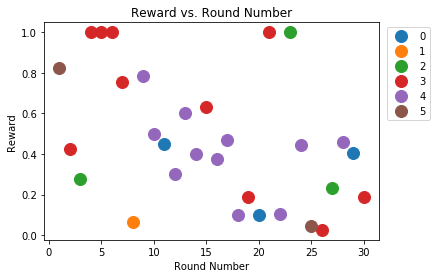

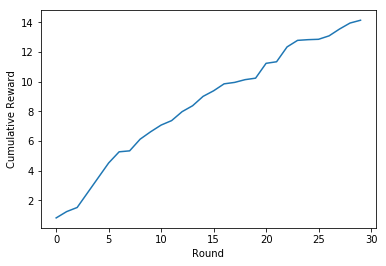

In [11]:
s1, r1 = thompson_sampling(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s1, r1)

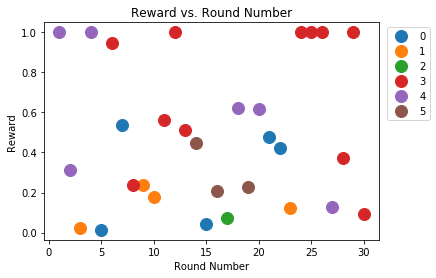

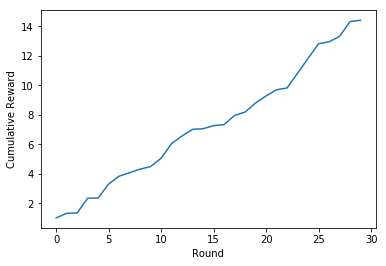

In [12]:
budget = 10
s2, r2 = thompson_sampling_with_budget(num_arms, num_episodes, budget, _beta)
singleGraph(num_arms, num_episodes, s2, r2)

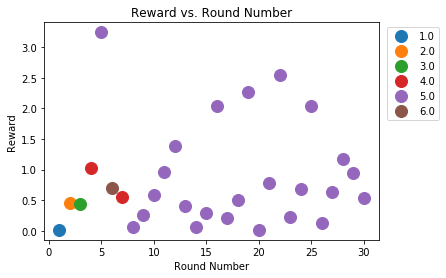

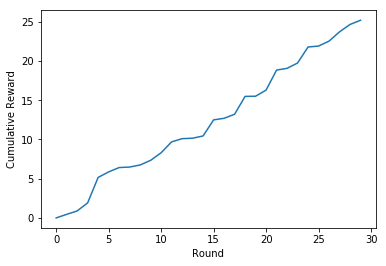

In [13]:
epsilon = 0.25
s3, r3 = peef(num_arms, num_episodes, epsilon, _beta)
singleGraph(num_arms, num_episodes, s3, r3)

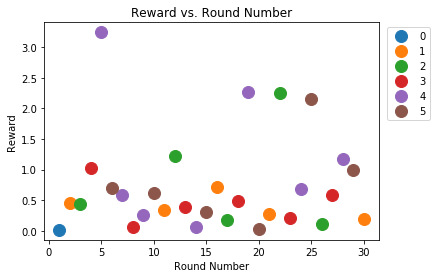

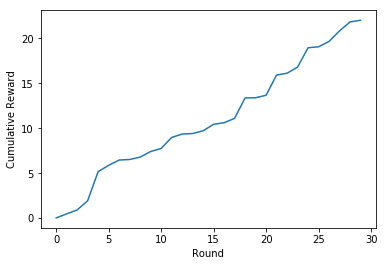

In [14]:
factor = 0.14
s4, r4 = SOAAv(num_arms, num_episodes, factor, _beta)
singleGraph(num_arms, num_episodes, s4, r4)

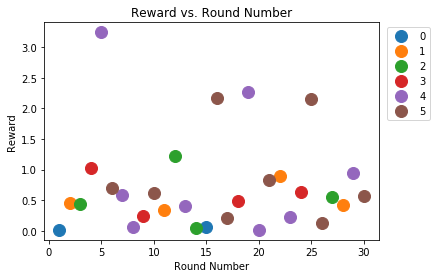

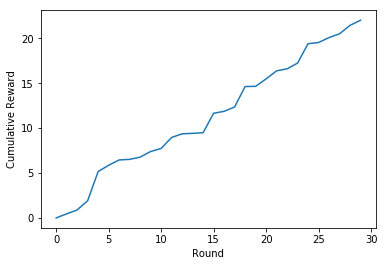

In [15]:
s5, r5 = UCB_algorithm(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s5, r5)

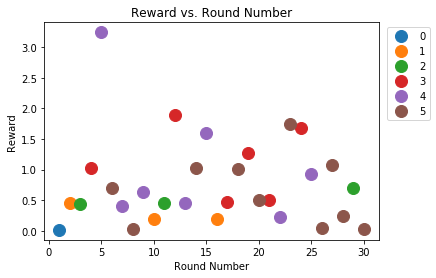

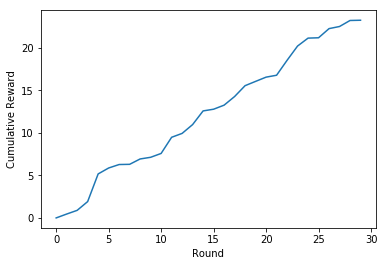

In [16]:
s6, r6 = exponential_thompson_sampling(num_arms, num_episodes, _beta)
singleGraph(num_arms, num_episodes, s6, r6)

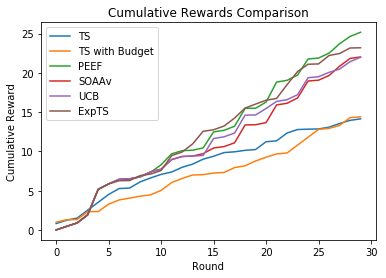

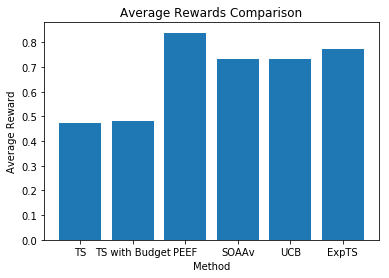

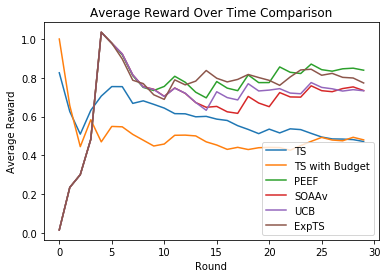

In [17]:
multiGraph(num_arms, num_episodes, budget, epsilon, factor, _beta)

['82.6', '42.6', '27.7', '100.0', '100.0', '100.0', '75.2', '6.4', '78.6', '50.0', '45.1', '30.1', '60.3', '39.8', '63.2', '37.5', '46.9', '9.7', '18.5', '10.1', '100.0', '10.6', '100.0', '44.2', '4.7', '2.6', '23.1', '46.1', '40.3', '18.8', '86.0', '95.2', '100.0']
['0.8', '0.4', '0.3', '1.0', '1.0', '1.0', '0.8', '0.1', '0.8', '0.5', '0.5', '0.3', '0.6', '0.4', '0.6', '0.4', '0.5', '0.1', '0.2', '0.1', '1.0', '0.1', '1.0', '0.4', '0.0', '0.0', '0.2', '0.5', '0.4', '0.2', '0.9', '1.0', '1.0']
Total rewards:1696.16
Avg rewards:16.96


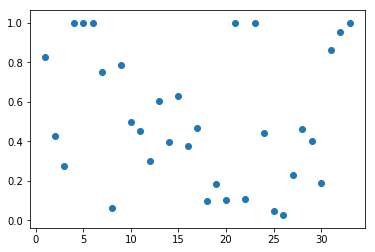

['82.6', '32.0', '16.6', '95.6', '100.0', '99.0', '56.4', '6.4', '69.4', '44.1', '12.2', '21.2', '21.8', '21.1', '81.0', '38.3', '34.5', '100.0', '41.2', '42.1', '69.4', '28.0', '100.0', '8.5', '0.9', '100.0', '71.6', '100.0', '21.5', '13.5', '12.9', '83.6', '100.0']
['0.8', '0.3', '0.2', '1.0', '1.0', '1.0', '0.6', '0.1', '0.7', '0.4', '0.1', '0.2', '0.2', '0.2', '0.8', '0.4', '0.3', '1.0', '0.4', '0.4', '0.7', '0.3', '1.0', '0.1', '0.0', '1.0', '0.7', '1.0', '0.2', '0.1', '0.1', '0.8', '1.0']
Total rewards:1725.47
Avg rewards:17.25


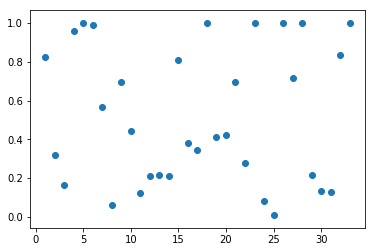

['27.5', '47.9', '100.0', '100.0', '27.5', '100.0', '100.0', '100.0', '18.5', '100.0', '67.7', '44.2', '100.0', '24.4', '32.1', '33.1', '9.6', '100.0', '8.7', '25.3', '100.0', '36.4', '100.0', '13.2', '13.1', '100.0', '23.6', '100.0', '55.0', '29.6', '80.4', '83.7', '4.5']
['0.3', '0.5', '1.0', '1.0', '0.3', '1.0', '1.0', '1.0', '0.2', '1.0', '0.7', '0.4', '1.0', '0.2', '0.3', '0.3', '0.1', '1.0', '0.1', '0.3', '1.0', '0.4', '1.0', '0.1', '0.1', '1.0', '0.2', '1.0', '0.6', '0.3', '0.8', '0.8', '0.0']
Total rewards:1906.14
Avg rewards:19.06


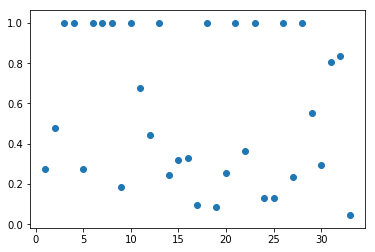

['82.6', '42.6', '27.7', '100.0', '100.0', '100.0', '75.2', '15.0', '78.6', '50.0', '100.0', '30.1', '60.3', '100.0', '2.6', '52.4', '81.0', '100.0', '66.3', '56.9', '58.0', '57.1', '84.7', '27.8', '21.7', '2.7', '100.0', '11.5', '100.0', '60.0', '57.6', '46.0', '75.0']
['0.8', '0.4', '0.3', '1.0', '1.0', '1.0', '0.8', '0.1', '0.8', '0.5', '1.0', '0.3', '0.6', '1.0', '0.0', '0.5', '0.8', '1.0', '0.7', '0.6', '0.6', '0.6', '0.8', '0.3', '0.2', '0.0', '1.0', '0.1', '1.0', '0.6', '0.6', '0.5', '0.8']
Total rewards:2023.47
Avg rewards:20.23


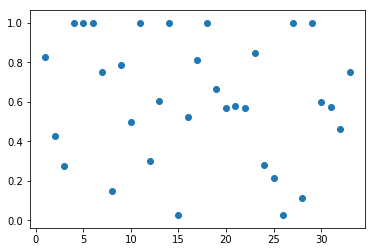

In [18]:
num_arms = 6
num_episodes = 33
num_runs = 100
betas = [[0.2, 0.3, 0.75, 0.8, 0.85, 0.9], 
         [0.15, 0.3, 0.45, 0.6, 0.75, 0.9], 
         [0.75, 0.8, 0.85, 0.9, 0.2, 0.3], 
         [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]]

ts_t_e = []
ts_a_e = []
ts_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = thompson_sampling(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ts_t_e.append(total_rewards_per_episode)
    ts_a_e.append(average_rewards_per_episode)
    ts_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['100.0', '31.3', '2.2', '100.0', '1.4', '94.7', '2.6', '65.2', '100.0', '100.0', '79.2', '100.0', '100.0', '95.8', '25.3', '100.0', '100.0', '100.0', '58.4', '100.0', '30.5', '100.0', '86.8', '17.5', '100.0', '16.9', '100.0', '97.2', '35.3', '26.7', '21.9', '89.3', '100.0']
['1.0', '0.3', '0.0', '1.0', '0.0', '0.9', '0.0', '0.7', '1.0', '1.0', '0.8', '1.0', '1.0', '1.0', '0.3', '1.0', '1.0', '1.0', '0.6', '1.0', '0.3', '1.0', '0.9', '0.2', '1.0', '0.2', '1.0', '1.0', '0.4', '0.3', '0.2', '0.9', '1.0']
Total rewards:2278.36
Avg rewards:22.78


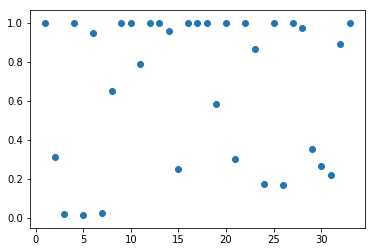

['100.0', '27.6', '2.2', '100.0', '1.0', '71.1', '2.6', '48.9', '96.3', '100.0', '29.8', '88.3', '100.0', '68.3', '60.1', '49.7', '100.0', '37.5', '49.0', '61.3', '73.3', '23.5', '22.6', '5.6', '100.0', '66.0', '26.2', '45.4', '24.5', '9.3', '53.1', '44.4', '8.6']
['1.0', '0.3', '0.0', '1.0', '0.0', '0.7', '0.0', '0.5', '1.0', '1.0', '0.3', '0.9', '1.0', '0.7', '0.6', '0.5', '1.0', '0.4', '0.5', '0.6', '0.7', '0.2', '0.2', '0.1', '1.0', '0.7', '0.3', '0.5', '0.2', '0.1', '0.5', '0.4', '0.1']
Total rewards:1696.23
Avg rewards:16.96


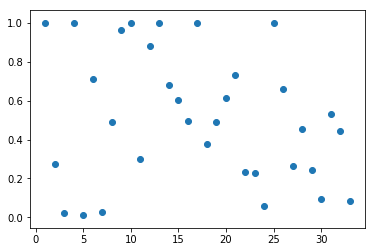

['30.3', '7.4', '6.0', '40.6', '5.1', '100.0', '47.3', '73.4', '22.6', '1.5', '22.6', '100.0', '46.8', '44.4', '71.3', '70.3', '14.9', '1.7', '100.0', '86.9', '59.7', '18.6', '5.4', '100.0', '5.6', '67.6', '65.1', '100.0', '84.8', '100.0', '65.0', '100.0', '100.0']
['0.3', '0.1', '0.1', '0.4', '0.1', '1.0', '0.5', '0.7', '0.2', '0.0', '0.2', '1.0', '0.5', '0.4', '0.7', '0.7', '0.1', '0.0', '1.0', '0.9', '0.6', '0.2', '0.1', '1.0', '0.1', '0.7', '0.7', '1.0', '0.8', '1.0', '0.7', '1.0', '1.0']
Total rewards:1764.95
Avg rewards:17.65


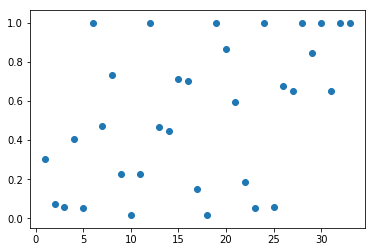

['100.0', '31.3', '5.2', '100.0', '4.4', '94.7', '6.1', '65.2', '100.0', '100.0', '79.2', '100.0', '100.0', '95.8', '25.3', '100.0', '100.0', '100.0', '58.4', '100.0', '30.5', '100.0', '86.8', '17.5', '100.0', '16.9', '100.0', '97.2', '35.3', '26.7', '21.9', '89.3', '100.0']
['1.0', '0.3', '0.1', '1.0', '0.0', '0.9', '0.1', '0.7', '1.0', '1.0', '0.8', '1.0', '1.0', '1.0', '0.3', '1.0', '1.0', '1.0', '0.6', '1.0', '0.3', '1.0', '0.9', '0.2', '1.0', '0.2', '1.0', '1.0', '0.4', '0.3', '0.2', '0.9', '1.0']
Total rewards:2287.91
Avg rewards:22.88


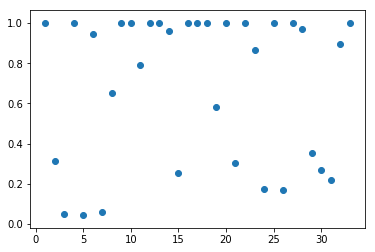

In [19]:
budget = 6
tsb_t_e = []
tsb_a_e = []
tsb_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = thompson_sampling_with_budget(num_arms, num_episodes, budget, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    tsb_t_e.append(total_rewards_per_episode)
    tsb_a_e.append(average_rewards_per_episode)
    tsb_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '55.6', '6.4', '26.6', '58.9', '96.6', '138.4', '40.8', '5.8', '28.9', '204.3', '20.4', '51.1', '227.5', '2.1', '78.0', '254.9', '22.2', '67.6', '203.9', '12.1', '63.0', '118.0', '94.0', '53.6', '19.5', '57.4', '39.6']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.3', '0.6', '1.0', '1.4', '0.4', '0.1', '0.3', '2.0', '0.2', '0.5', '2.3', '0.0', '0.8', '2.5', '0.2', '0.7', '2.0', '0.1', '0.6', '1.2', '0.9', '0.5', '0.2', '0.6', '0.4']
Total rewards:2634.23
Avg rewards:26.34


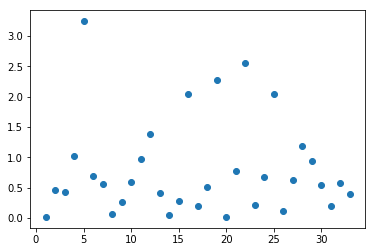

['1.2', '45.4', '26.0', '77.1', '286.2', '69.6', '41.7', '5.6', '23.4', '52.0', '85.3', '122.1', '36.0', '5.1', '25.5', '180.3', '18.0', '45.1', '200.7', '1.9', '68.8', '224.9', '19.6', '59.6', '179.9', '10.7', '55.6', '104.1', '82.9', '47.3', '17.2', '50.6', '34.9']
['0.0', '0.5', '0.3', '0.8', '2.9', '0.7', '0.4', '0.1', '0.2', '0.5', '0.9', '1.2', '0.4', '0.1', '0.3', '1.8', '0.2', '0.5', '2.0', '0.0', '0.7', '2.2', '0.2', '0.6', '1.8', '0.1', '0.6', '1.0', '0.8', '0.5', '0.2', '0.5', '0.3']
Total rewards:2304.45
Avg rewards:23.04


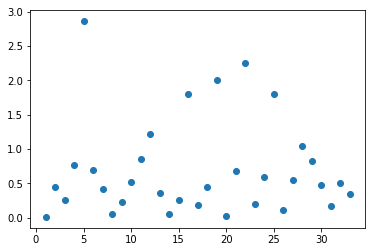

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '55.6', '6.7', '25.0', '13.9', '91.0', '130.3', '38.4', '5.5', '27.2', '192.3', '19.2', '48.1', '214.1', '2.0', '73.4', '239.9', '20.9', '63.6', '191.9', '11.4', '59.3', '111.0', '88.5', '50.5', '18.3', '54.0', '37.3']
['0.1', '1.2', '0.5', '1.2', '0.8', '0.2', '0.6', '0.1', '0.3', '0.1', '0.9', '1.3', '0.4', '0.1', '0.3', '1.9', '0.2', '0.5', '2.1', '0.0', '0.7', '2.4', '0.2', '0.6', '1.9', '0.1', '0.6', '1.1', '0.9', '0.5', '0.2', '0.5', '0.4']
Total rewards:2280.48
Avg rewards:22.80


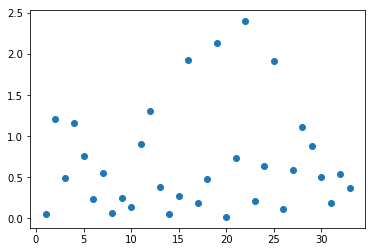

['5.2', '106.0', '43.3', '102.8', '324.4', '69.6', '48.7', '6.4', '26.6', '58.9', '96.6', '130.3', '38.4', '5.8', '27.2', '204.3', '20.4', '51.1', '227.5', '2.1', '78.0', '254.9', '22.2', '67.6', '203.9', '12.1', '63.0', '118.0', '94.0', '53.6', '19.5', '57.4', '39.6']
['0.1', '1.1', '0.4', '1.0', '3.2', '0.7', '0.5', '0.1', '0.3', '0.6', '1.0', '1.3', '0.4', '0.1', '0.3', '2.0', '0.2', '0.5', '2.3', '0.0', '0.8', '2.5', '0.2', '0.7', '2.0', '0.1', '0.6', '1.2', '0.9', '0.5', '0.2', '0.6', '0.4']
Total rewards:2679.16
Avg rewards:26.79


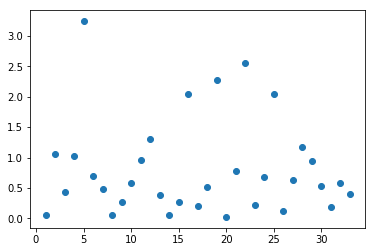

In [20]:
epsilon = 0.25
peef_t_e = []
peef_a_e = []
peef_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = peef(num_arms, num_episodes, epsilon, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    peef_t_e.append(total_rewards_per_episode)
    peef_a_e.append(average_rewards_per_episode)
    peef_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '59.1', '6.0', '26.6', '62.4', '34.1', '122.1', '38.4', '5.8', '30.6', '72.1', '18.0', '48.1', '227.5', '2.3', '27.5', '224.9', '20.9', '67.6', '215.8', '10.7', '59.3', '118.0', '99.5', '18.9', '17.2', '54.0', '39.6']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.3', '0.6', '0.3', '1.2', '0.4', '0.1', '0.3', '0.7', '0.2', '0.5', '2.3', '0.0', '0.3', '2.2', '0.2', '0.7', '2.2', '0.1', '0.6', '1.2', '1.0', '0.2', '0.2', '0.5', '0.4']
Total rewards:2314.08
Avg rewards:23.14


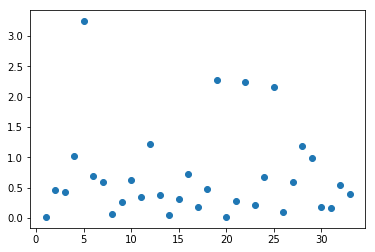

['1.2', '45.4', '26.0', '77.1', '286.2', '69.6', '52.2', '4.5', '23.4', '62.4', '34.1', '97.7', '36.0', '6.1', '10.2', '144.2', '18.0', '54.2', '80.3', '1.5', '68.8', '269.8', '15.7', '59.6', '215.8', '8.6', '55.6', '124.9', '33.2', '37.8', '17.2', '60.7', '14.0']
['0.0', '0.5', '0.3', '0.8', '2.9', '0.7', '0.5', '0.0', '0.2', '0.6', '0.3', '1.0', '0.4', '0.1', '0.1', '1.4', '0.2', '0.5', '0.8', '0.0', '0.7', '2.7', '0.2', '0.6', '2.2', '0.1', '0.6', '1.2', '0.3', '0.4', '0.2', '0.6', '0.1']
Total rewards:2112.08
Avg rewards:21.12


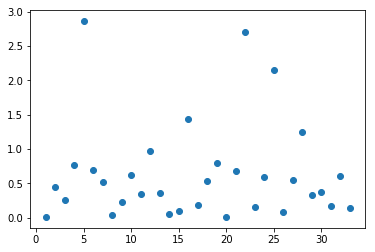

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '55.6', '6.7', '6.3', '55.4', '96.6', '146.5', '9.6', '5.5', '28.9', '216.3', '19.2', '51.1', '240.9', '2.0', '78.0', '269.8', '20.9', '67.6', '215.8', '11.4', '63.0', '124.9', '88.5', '53.6', '20.6', '13.5', '37.3']
['0.1', '1.2', '0.5', '1.2', '0.8', '0.2', '0.6', '0.1', '0.1', '0.6', '1.0', '1.5', '0.1', '0.1', '0.3', '2.2', '0.2', '0.5', '2.4', '0.0', '0.8', '2.7', '0.2', '0.7', '2.2', '0.1', '0.6', '1.2', '0.9', '0.5', '0.2', '0.1', '0.4']
Total rewards:2397.08
Avg rewards:23.97


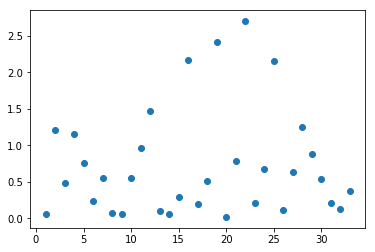

['5.2', '106.0', '43.3', '102.8', '324.4', '69.6', '59.1', '5.2', '25.0', '58.9', '102.3', '114.0', '38.4', '5.8', '30.6', '168.2', '19.2', '51.1', '240.9', '1.8', '78.0', '269.8', '18.3', '63.6', '203.9', '12.9', '51.9', '111.0', '94.0', '56.8', '16.0', '54.0', '39.6']
['0.1', '1.1', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.3', '0.6', '1.0', '1.1', '0.4', '0.1', '0.3', '1.7', '0.2', '0.5', '2.4', '0.0', '0.8', '2.7', '0.2', '0.6', '2.0', '0.1', '0.5', '1.1', '0.9', '0.6', '0.2', '0.5', '0.4']
Total rewards:2641.55
Avg rewards:26.42


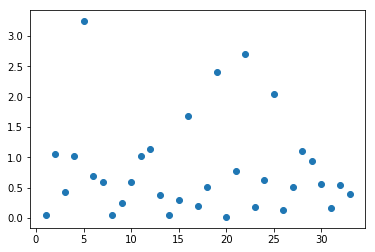

In [21]:
factor = 0.14
soaav_t_e = []
soaav_a_e = []
soaav_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = SOAAv(num_arms, num_episodes, factor, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    soaav_t_e.append(total_rewards_per_episode)
    soaav_a_e.append(average_rewards_per_episode)
    soaav_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '59.1', '6.4', '25.0', '62.4', '34.1', '122.1', '40.8', '5.1', '6.8', '216.3', '21.6', '48.1', '227.5', '2.1', '82.6', '89.9', '22.2', '63.6', '215.8', '12.9', '55.6', '41.6', '94.0', '56.8', '18.3', '57.4', '9.3']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.3', '0.6', '0.3', '1.2', '0.4', '0.1', '0.1', '2.2', '0.2', '0.5', '2.3', '0.0', '0.8', '0.9', '0.2', '0.6', '2.2', '0.1', '0.6', '0.4', '0.9', '0.6', '0.2', '0.6', '0.1']
Total rewards:2284.62
Avg rewards:22.85


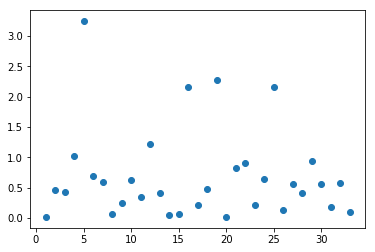

['1.2', '45.4', '26.0', '77.1', '286.2', '69.6', '52.2', '5.6', '18.8', '62.4', '34.1', '73.3', '36.0', '1.0', '30.6', '108.2', '14.4', '45.1', '80.3', '1.1', '82.6', '89.9', '19.6', '23.9', '215.8', '12.9', '44.5', '124.9', '16.6', '56.8', '10.3', '50.6', '41.9']
['0.0', '0.5', '0.3', '0.8', '2.9', '0.7', '0.5', '0.1', '0.2', '0.6', '0.3', '0.7', '0.4', '0.0', '0.3', '1.1', '0.1', '0.5', '0.8', '0.0', '0.8', '0.9', '0.2', '0.2', '2.2', '0.1', '0.4', '1.2', '0.2', '0.6', '0.1', '0.5', '0.4']
Total rewards:1858.78
Avg rewards:18.59


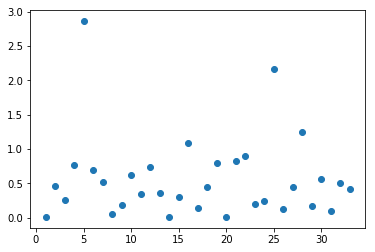

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '55.6', '6.7', '6.3', '58.9', '91.0', '48.8', '36.0', '6.1', '27.2', '204.3', '20.4', '12.0', '80.3', '2.1', '73.4', '224.9', '19.6', '59.6', '71.9', '12.9', '59.3', '41.6', '82.9', '53.6', '4.6', '50.6', '37.3']
['0.1', '1.2', '0.5', '1.2', '0.8', '0.2', '0.6', '0.1', '0.1', '0.6', '0.9', '0.5', '0.4', '0.1', '0.3', '2.0', '0.2', '0.1', '0.8', '0.0', '0.7', '2.2', '0.2', '0.6', '0.7', '0.1', '0.6', '0.4', '0.8', '0.5', '0.0', '0.5', '0.4']
Total rewards:1839.39
Avg rewards:18.39


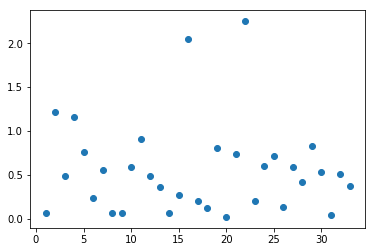

['5.2', '106.0', '43.3', '102.8', '324.4', '69.6', '59.1', '6.4', '21.9', '55.4', '102.3', '122.1', '40.8', '6.1', '25.5', '192.3', '19.2', '39.1', '187.4', '1.8', '78.0', '239.9', '20.9', '67.6', '179.9', '10.7', '59.3', '97.2', '99.5', '41.0', '19.5', '60.7', '32.6']
['0.1', '1.1', '0.4', '1.0', '3.2', '0.7', '0.6', '0.1', '0.2', '0.6', '1.0', '1.2', '0.4', '0.1', '0.3', '1.9', '0.2', '0.4', '1.9', '0.0', '0.8', '2.4', '0.2', '0.7', '1.8', '0.1', '0.6', '1.0', '1.0', '0.4', '0.2', '0.6', '0.3']
Total rewards:2537.31
Avg rewards:25.37


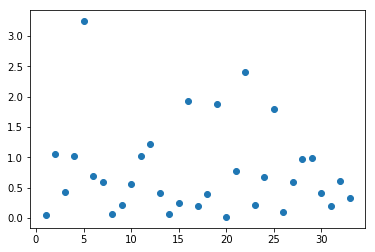

In [22]:
ucb_t_e = []
ucb_a_e = []
ucb_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = UCB_algorithm(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ucb_t_e.append(total_rewards_per_episode)
    ucb_a_e.append(average_rewards_per_episode)
    ucb_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

['1.6', '45.4', '43.3', '102.8', '324.4', '69.6', '40.8', '2.3', '63.0', '19.5', '45.2', '189.5', '45.6', '103.4', '160.4', '20.0', '47.6', '101.1', '127.5', '50.2', '49.8', '22.3', '175.0', '167.5', '93.0', '4.1', '107.4', '24.9', '70.5', '2.8', '61.3', '6.9', '9.7']
['0.0', '0.5', '0.4', '1.0', '3.2', '0.7', '0.4', '0.0', '0.6', '0.2', '0.5', '1.9', '0.5', '1.0', '1.6', '0.2', '0.5', '1.0', '1.3', '0.5', '0.5', '0.2', '1.8', '1.7', '0.9', '0.0', '1.1', '0.2', '0.7', '0.0', '0.6', '0.1', '0.1']
Total rewards:2397.99
Avg rewards:23.98


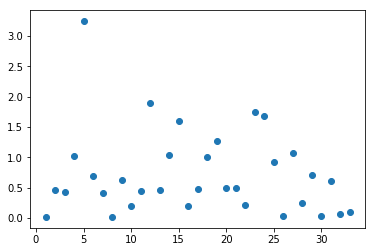

['1.2', '45.4', '26.0', '77.1', '286.2', '69.6', '36.0', '2.3', '55.6', '19.5', '27.1', '177.7', '32.2', '103.4', '141.5', '20.0', '53.5', '84.3', '95.6', '50.2', '37.3', '19.6', '175.0', '125.6', '82.0', '4.1', '107.4', '24.9', '42.3', '2.8', '45.9', '6.9', '9.7']
['0.0', '0.5', '0.3', '0.8', '2.9', '0.7', '0.4', '0.0', '0.6', '0.2', '0.3', '1.8', '0.3', '1.0', '1.4', '0.2', '0.5', '0.8', '1.0', '0.5', '0.4', '0.2', '1.8', '1.3', '0.8', '0.0', '1.1', '0.2', '0.4', '0.0', '0.5', '0.1', '0.1']
Total rewards:2087.84
Avg rewards:20.88


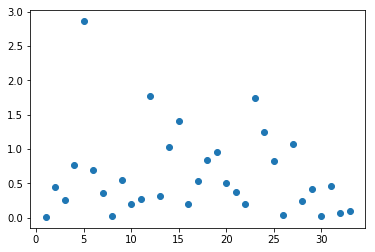

['6.0', '121.1', '49.0', '115.7', '76.3', '23.2', '9.6', '2.1', '59.3', '51.9', '48.2', '213.2', '48.2', '34.5', '37.7', '53.2', '53.5', '33.7', '143.4', '16.7', '56.0', '5.2', '175.0', '188.4', '98.4', '1.4', '95.4', '5.5', '80.0', '2.3', '68.9', '18.5', '25.9']
['0.1', '1.2', '0.5', '1.2', '0.8', '0.2', '0.1', '0.0', '0.6', '0.5', '0.5', '2.1', '0.5', '0.3', '0.4', '0.5', '0.5', '0.3', '1.4', '0.2', '0.6', '0.1', '1.8', '1.9', '1.0', '0.0', '1.0', '0.1', '0.8', '0.0', '0.7', '0.2', '0.3']
Total rewards:2017.62
Avg rewards:20.18


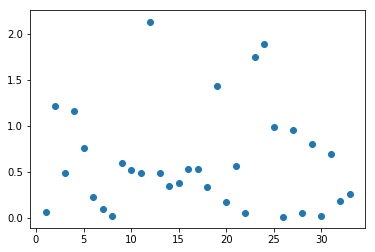

['5.2', '106.0', '43.3', '102.8', '324.4', '69.6', '40.8', '2.3', '51.9', '55.2', '42.2', '189.5', '45.6', '103.4', '160.4', '46.6', '47.6', '101.1', '127.5', '41.9', '49.8', '22.3', '175.0', '167.5', '93.0', '4.1', '107.4', '24.9', '70.5', '2.8', '61.3', '16.2', '22.6']
['0.1', '1.1', '0.4', '1.0', '3.2', '0.7', '0.4', '0.0', '0.5', '0.6', '0.4', '1.9', '0.5', '1.0', '1.6', '0.5', '0.5', '1.0', '1.3', '0.4', '0.5', '0.2', '1.8', '1.7', '0.9', '0.0', '1.1', '0.2', '0.7', '0.0', '0.6', '0.2', '0.2']
Total rewards:2524.09
Avg rewards:25.24


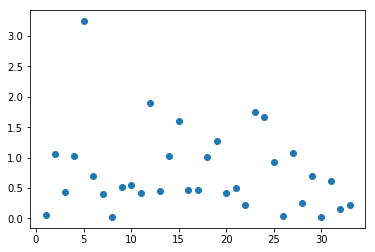

In [23]:
ets_t_e = []
ets_a_e = []
ets_t = []
for beta in betas:
    total_r = 0
    total_rewards_per_episode = [0] * num_episodes
    average_rewards_per_episode = [0] * num_episodes
    for i in range(100):
        _, rewards = exponential_thompson_sampling(num_arms, num_episodes, beta)
        total_r += np.sum(rewards)
        for episode in range(num_episodes):
            total_rewards_per_episode[episode] += rewards[episode]

    # Calculate the average reward for each episode
    average_rewards_per_episode = [total_reward / 100 for total_reward in total_rewards_per_episode]
    ets_t_e.append(total_rewards_per_episode)
    ets_a_e.append(average_rewards_per_episode)
    ets_t.append(total_r) 
    print([f"{reward:.1f}" for reward in total_rewards_per_episode])
    print([f"{reward:.1f}" for reward in average_rewards_per_episode])
    print(f"Total rewards:{total_r:.2f}")
    print(f"Avg rewards:{total_r/100:.2f}")
    plt.scatter(np.arange(1, num_episodes+1), average_rewards_per_episode, label=str(beta))
    plt.show()

In [24]:
print("Total Rewards over 4 sets of Beta values:")
print("TS")
print(ts_t)
print("TS with budget")
print(tsb_t)
print("peef")
print(peef_t)
print("SOAAv")
print(soaav_t)
print("UCB")
print(ucb_t)
print("ExpTS")
print(ets_t)

Total Rewards over 4 sets of Beta values:
TS
[1696.1602650440402, 1725.4682300335403, 1906.1377141469864, 2023.4686035120549]
TS with budget
[2278.362345186088, 1696.2295015745144, 1764.9533246560445, 2287.9110542481617]
peef
[2634.2333498068315, 2304.451897559464, 2280.48457764701, 2679.1630172440687]
SOAAv
[2314.080653357151, 2112.0829841256177, 2397.0784528516265, 2641.5519375847744]
UCB
[2284.618063508465, 1858.7778712818076, 1839.3852431980563, 2537.309608267419]
ExpTS
[2397.994267003439, 2087.842619482648, 2017.6208529463797, 2524.0902144298757]


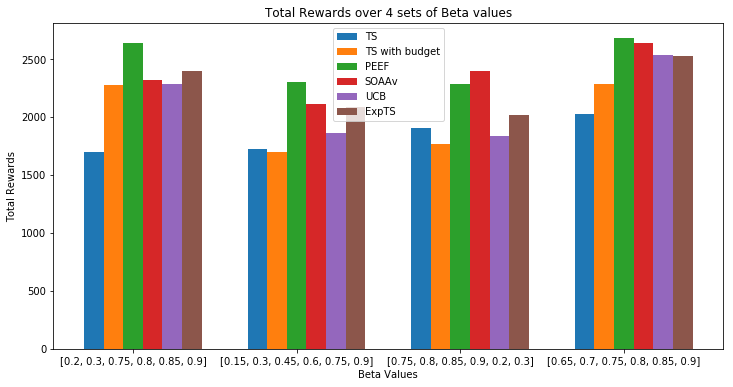

In [25]:
n_betas = len(betas)
bar_width = 0.12

x = np.arange(n_betas)

plt.figure(figsize=(12, 6))
plt.bar(x - 2*bar_width, ts_t, width=bar_width, label='TS')
plt.bar(x - bar_width, tsb_t, width=bar_width, label='TS with budget')
plt.bar(x, peef_t, width=bar_width, label='PEEF')
plt.bar(x + bar_width, soaav_t, width=bar_width, label='SOAAv')
plt.bar(x + 2*bar_width, ucb_t, width=bar_width, label='UCB')
plt.bar(x + 3*bar_width, ets_t, width=bar_width, label='ExpTS')

# Adding labels and title
plt.xlabel('Beta Values')
plt.ylabel('Total Rewards')
plt.title('Total Rewards over 4 sets of Beta values')
plt.xticks(x, betas)
plt.legend()
plt.show()

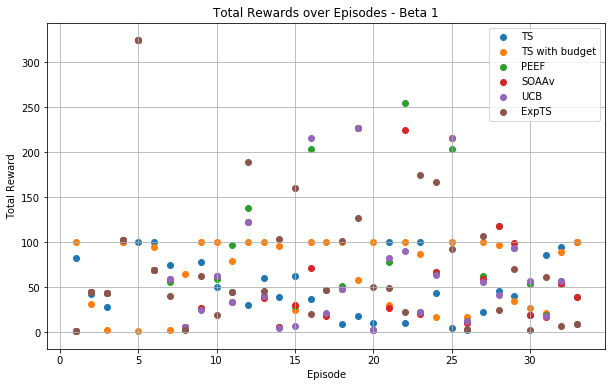

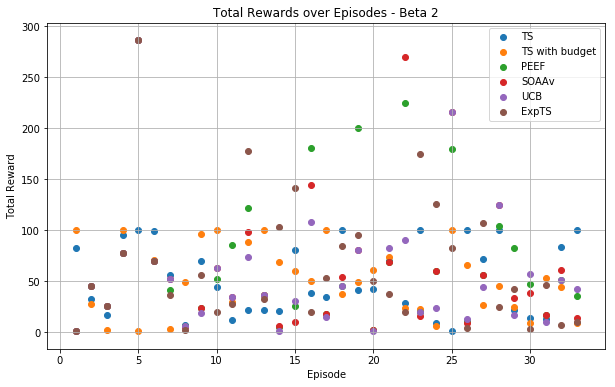

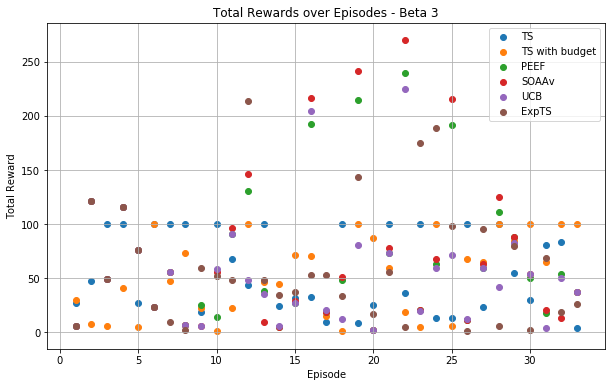

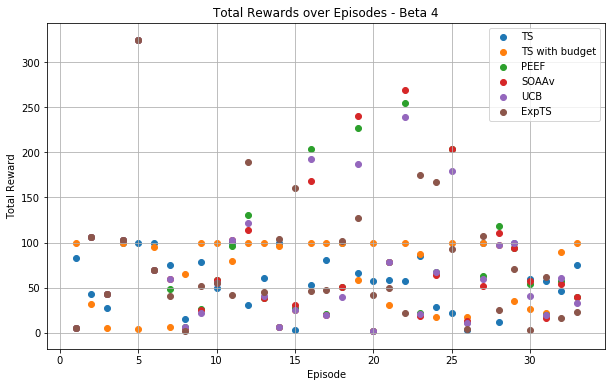

In [26]:
for i in range(4):
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Plot the total rewards for each method
    plt.scatter(np.arange(1, num_episodes+1), ts_t_e[i], label='TS')
    plt.scatter(np.arange(1, num_episodes+1), tsb_t_e[i], label='TS with budget')
    plt.scatter(np.arange(1, num_episodes+1), peef_t_e[i], label='PEEF')
    plt.scatter(np.arange(1, num_episodes+1), soaav_t_e[i], label='SOAAv')
    plt.scatter(np.arange(1, num_episodes+1), ucb_t_e[i], label='UCB')
    plt.scatter(np.arange(1, num_episodes+1), ets_t_e[i], label='ExpTS')
    
    # Adding labels and title
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Total Rewards over Episodes - Beta {i+1}')
    plt.legend()
    plt.grid()
    plt.show()

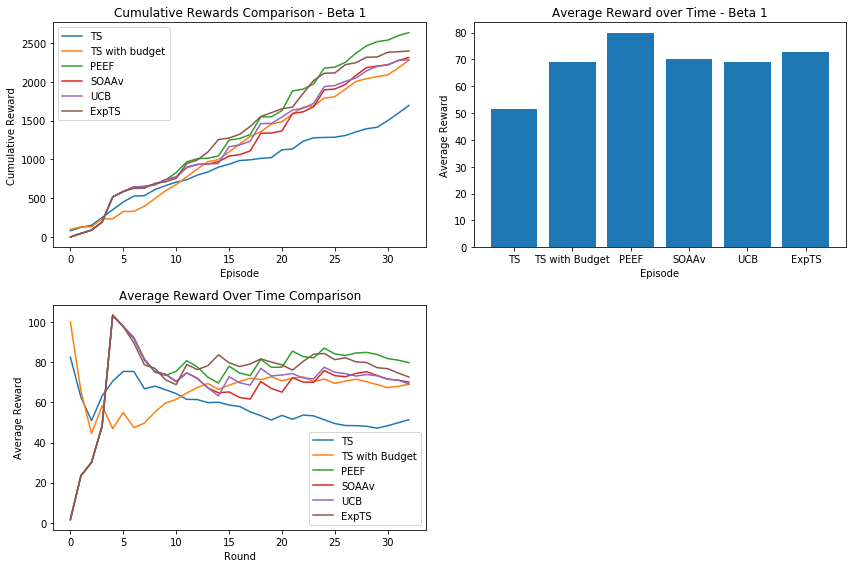

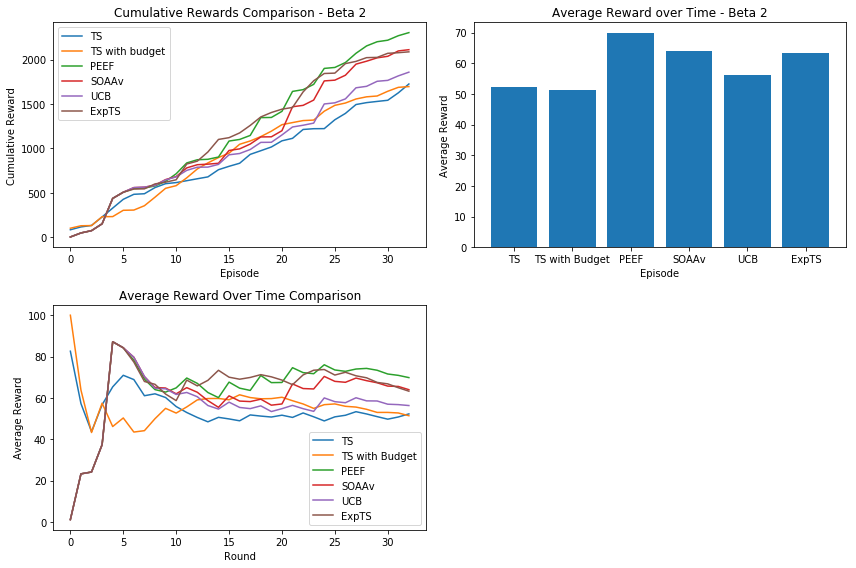

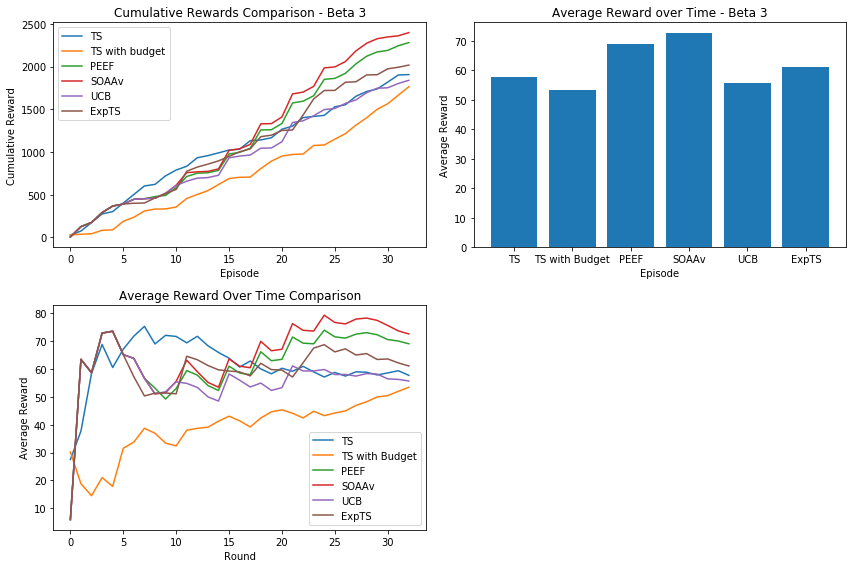

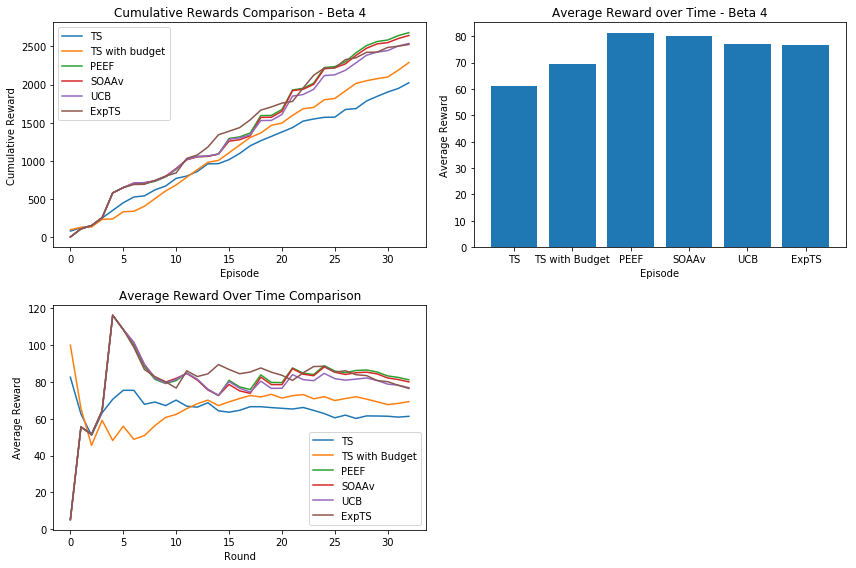

In [27]:
for i in range(4):
    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Cumulative rewards comparison
    plt.subplot(2, 2, 1)
    plt.plot(np.cumsum(ts_t_e[i]), label='TS')
    plt.plot(np.cumsum(tsb_t_e[i]), label='TS with budget')
    plt.plot(np.cumsum(peef_t_e[i]), label='PEEF')
    plt.plot(np.cumsum(soaav_t_e[i]), label='SOAAv')
    plt.plot(np.cumsum(ucb_t_e[i]), label='UCB')
    plt.plot(np.cumsum(ets_t_e[i]), label='ExpTS')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Rewards Comparison - Beta {i+1}')
    plt.legend()

    # Average reward
    plt.subplot(2, 2, 2)
    avg_rewards = [np.mean(ts_t_e[i]), np.mean(tsb_t_e[i]), np.mean(peef_t_e[i]), np.mean(soaav_t_e[i]), np.mean(ucb_t_e[i]), np.mean(ets_t_e[i])]
    methods = ['TS', 'TS with Budget', 'PEEF', 'SOAAv', 'UCB', 'ExpTS']
    plt.bar(methods, avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Average Reward over Time - Beta {i+1}')
    
    # Average reward over time plot
    plt.subplot(2, 2, 3)
    average_reward_over_time_1 = np.cumsum(ts_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_2 = np.cumsum(tsb_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_3 = np.cumsum(peef_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_4 = np.cumsum(soaav_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_5 = np.cumsum(ucb_t_e[i]) / np.arange(1, num_episodes+1)
    average_reward_over_time_6 = np.cumsum(ets_t_e[i]) / np.arange(1, num_episodes+1)

    plt.plot(average_reward_over_time_1, label='TS')
    plt.plot(average_reward_over_time_2, label='TS with Budget')
    plt.plot(average_reward_over_time_3, label='PEEF')
    plt.plot(average_reward_over_time_4, label='SOAAv')
    plt.plot(average_reward_over_time_5, label='UCB')
    plt.plot(average_reward_over_time_6, label='ExpTS')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time Comparison')
    plt.legend()
    

    # Adding space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()